## Import dependencies

In [1]:
# pip install tensorflow

In [2]:
import mediapipe as mp
import numpy as np
import cv2 as cv2
import os
from matplotlib import pyplot as plt
import time

## Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color = (51,255,255), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color = (153,0,76), thickness=1, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (51,102,0), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (102,78,255), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))

In [6]:
cap = cv2.VideoCapture(0);
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5 ) as holistic:
    while cap.isOpened():
        ret,frame = cap.read()
        image, results = mediapipe_detection(frame,holistic)
#         print(results)
        draw_styled_landmarks(image,results)
        cv2.imshow('OpenCv Window',image)
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [7]:
draw_styled_landmarks(frame,results) 

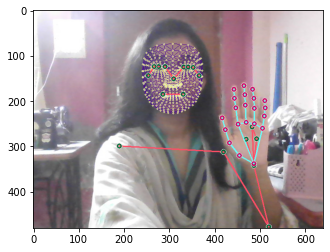

In [8]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [9]:
# img = cv2.imread("img.jpg")

In [10]:
# with mp_holistic.Holistic(static_image_mode=True) as holistic :
#     result = holistic.process(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#     print('NOSE world landmarks : ')
#     print(result.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.NOSE])
    
# #     Plot pose world landmarks
#     mp_drawing.plot_landmarks(
#     result.pose_world_landmarks,mp_holistic.POSE_CONNECTIONS)

## Extract key value points

In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404) 
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63) 
    return np.concatenate([pose,face,lh,rh])

In [12]:
result_test = extract_keypoints(results)

In [13]:
result_test.shape

(1662,)

In [14]:
np.save('0', result_test)

## Setup Folders for Collection

In [15]:
DATA_PATH = os.path.join('MP_DATA')
actions = np.array(['hello','thanks','iloveyou'])
no_seq = 30
seq_len = 30
st_folder = 30

In [16]:
for action in actions :
    for sequence in range(no_seq) :
        try :
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except :
            pass

## Collect Keypoints values for training and testing

In [17]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5 ) as holistic:
    
    # NEW LOOP through actions
    for action in actions :
        for sequence in range(no_seq) :
            for frame_num in range(seq_len) :
                ret,frame = cap.read()
                image, results = mediapipe_detection(frame,holistic)
                # print(results)
                draw_styled_landmarks(image,results)
                
                # New "Apply wait" logic
                if frame_num == 0 :
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),1,cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCv Window',image)
                    cv2.waitKey(2000)
                else :
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                     # Show to screen
                    cv2.imshow('OpenCv Window',image)
                    
                # NEW EXPORT keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence),str(frame_num))
                np.save(npy_path, keypoints)
                
                if cv2.waitKey(10) & 0xff == ord('q'):
                    break
        
    cap.release()
    cv2.destroyAllWindows()

In [18]:
cap.release()
cv2.destroyAllWindows()

In [19]:
np.load(r'C:\Users\Nida Shaikh\JuPyNB\SemV_MP\MP_DATA\hello\15\15.npy')

array([ 0.53686833,  0.42471212, -0.38113827, ...,  0.44441944,
        0.34592995, -0.01333776])

In [20]:
keypoints.shape

(1662,)

## Preprocess data and create labels

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [22]:
label_map = {label:num for num,label in enumerate(actions)}

In [23]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [24]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_seq):
        window = []
        for frame_num in range(seq_len):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [25]:
np.array(sequences).shape

(90, 30, 1662)

In [26]:
np.array(labels).shape

(90,)

In [27]:
# sequences.shape

In [28]:
X = np.array(sequences)

In [29]:
X.shape

(90, 30, 1662)

In [30]:
y = to_categorical(labels).astype(int)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

# Build and Train LSTM Neural Network

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [33]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir)

In [34]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation = 'relu'))
model.add(LSTM(128, return_sequences=True, activation = 'relu'))
model.add(LSTM(64, return_sequences=False, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(actions.shape[0], activation = 'softmax'))

In [35]:
actions.shape[0]

3

In [36]:
res = model.predict(X_test)

1/1 [==============================] - 1s 747ms/step


In [37]:
res = [.7, 0.2, 0.1]

In [38]:
actions[np.argmax(res)]

'hello'

In [39]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [40]:
model.fit(X_train, y_train, epochs=40, callbacks=[tb_callback])

Epoch 1/40
3/3 [==============================] - 2s 58ms/step - loss: 1.2478 - categorical_accuracy: 0.2963
Epoch 2/40
3/3 [==============================] - 0s 56ms/step - loss: 1.1224 - categorical_accuracy: 0.5309
Epoch 3/40
3/3 [==============================] - 0s 58ms/step - loss: 2.1262 - categorical_accuracy: 0.2840
Epoch 4/40
3/3 [==============================] - 0s 58ms/step - loss: 1.0887 - categorical_accuracy: 0.4198
Epoch 5/40
3/3 [==============================] - 0s 57ms/step - loss: 1.0736 - categorical_accuracy: 0.7037
Epoch 6/40
3/3 [==============================] - 0s 57ms/step - loss: 1.0525 - categorical_accuracy: 0.7037
Epoch 7/40
3/3 [==============================] - 0s 57ms/step - loss: 0.9828 - categorical_accuracy: 0.6420
Epoch 8/40
3/3 [==============================] - 0s 57ms/step - loss: 0.7183 - categorical_accuracy: 0.7160
Epoch 9/40
3/3 [==============================] - 0s 57ms/step - loss: 1.2495 - categorical_accuracy: 0.6914
Epoch 10/40
3/3 [==

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

# Make predictions

In [42]:
res = model.predict(X_test)

1/1 [==============================] - 0s 373ms/step


In [43]:
actions[np.argmax(res[4])]

'thanks'

In [44]:
actions[np.argmax(y_test[4])]


'thanks'

#### Save weights

In [45]:
model.save('action.h5')

In [46]:
# del model

In [50]:
model.load_weights('action.h5')

NameError: name 'model' is not defined

# Evaluation using Confusion Matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

# Test in real time

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))